# Project: Distracted driver detection and classification using deep convolutional neural networks

## Description: 
This project aims to develop a machine learning system that can detect and classify different distracted states of car drivers. The main approach is to apply deep convolutional neural networks (CNNs). We will explore and experiment various CNN architectures, leveraged pre-trained networks (learning transfer), psuedo labelling, and potentially an emsenbles of several models to find the best classification. Results of this project may be used to further research and applied to as a part of an on-car online monitoring system where computer will decide to take-over control of the car if the driver is distracted and poses a potential accident.

## Data
Data is a collection of 10 different states of drivers containing one safe driving and 9 other distracted modes. The dataset is provided by State Farm through Kaggle which can be downloaded from [here](https://www.kaggle.com/c/state-farm-distracted-driver-detection/data). Data exploration and preprocessing will be described in details in subsequent sections.

## Analysis
Data exploration, preprocessing and analy will be conducted in great details to gain as much information about the dataset as possible. All steps of a machine learning pipeline are included and a summary is provided at the end of each section.

## Tools

The project utilizes the following dependencies:

- Python 3.5: Tensorflow, Keras, Numpy, Scipy
- NVIDIA Geforce GTX960 GPU, CUDA, CuDNN

# 1. Import dependencies

Check GPU device availability.


In [1]:
from tensorflow.python.client import device_lib
[x.physical_device_desc for x in device_lib.list_local_devices() if x.device_type == 'GPU']
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3148214895490216957
]


Basic import, if anything needed during the development process, dump here.

In [168]:
import math, os, sys
import pickle
from glob import glob
import numpy as np
from numpy.random import random, permutation, randn, normal
from matplotlib import pyplot as plt
%matplotlib inline
import PIL
from PIL import Image
import bcolz
from shutil import copyfile
from shutil import move
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.preprocessing import Imputer, LabelEncoder, OneHotEncoder, StandardScaler

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input,  GlobalAveragePooling2D, AveragePooling2D, GlobalAveragePooling1D, GlobalMaxPooling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing import image
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical
from keras.metrics import categorical_crossentropy
from keras.regularizers import l2,l1

Create some handy utilities, this block will be put in a separete script to import

In [131]:
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, 
                batch_size=1, target_size=(224,224), class_mode='categorical'):
    return gen.flow_from_directory(path+dirname, target_size, 
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

def get_classes(path):
    batches = get_batches('train', shuffle=False, batch_size=1)
    val_batches = get_batches('valid', shuffle=False, batch_size=1)
    test_batches = get_batches('test', shuffle=False, batch_size=1)
    return (val_batches.classes, 
            batches.classes,
            test_batches.classes,
            to_categorical(val_batches.classes),
            to_categorical(batches.classes),
            to_categorical(test_batches.classes),
            val_batches.filenames, 
            batches.filenames,
            test_batches.filenames)
           # test_batches.filenames)

def get_data(path, target_size = (224,224)):
    batches = get_batches(path, shuffle=False, batch_size=1, class_mode=None, target_size=target_size)
    return np.concatenate([batches.next() for i in range (len(batches.classes))])

def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()
    
def load_array(fname):
    return bcolz.open(fname)[:]

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
def plot_history(Exp_history):
    plt.figure(1)
    plt.subplot(211)
    plt.plot(Exp_history.history['acc'])
    plt.plot(Exp_history.history['val_acc'])
    plt.title('accuracy')
    plt.ylabel('accuracy')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.subplot(212)
    plt.plot(Exp_history.history['loss'])
    plt.plot(Exp_history.history['val_loss'])
    plt.title('loss')
    plt.ylabel('loss')
    plt.xlabel('epoches')
    plt.legend(['train', 'validation'], loc='upper left')
   
    #plt.savefig(results_path+'/train_history/Exp_train_history_1.png', bbox_inches='tight')
    plt.show()


def plot_acc(Exp_history):
    plt.figure(1)
    plt.plot(Exp_history.history['acc'])
    plt.plot(Exp_history.history['val_acc'])
    plt.title('accuracy')
    plt.ylabel('accuracy')
    plt.legend(['train', 'validation'], loc='upper left')
    #plt.savefig(results_path+'/train_history/Exp_train_history_1.png', bbox_inches='tight')
    plt.show()

# 1. Data preparation and exploration

As provided, the train dataset contains the following categories of driving states:

- c0: safe driving
- c1: texting - right
- c2: talking on the phone - right
- c3: texting - left
- c4: talking on the phone - left
- c5: operating the radio
- c6: drinking
- c7: reaching behind
- c8: hair and makeup
- c9: talking to passenger

## 1.1 Prepare data directories
As general, we will distribute the training data into train and validation sets. 


In [4]:

#%cd project
%pwd

'C:\\Users\\User\\Downloads\\udacity\\project'

In [5]:
current_dir = os.getcwd()
PROJECT_DIR = current_dir
path = current_dir+'/imgs/'
test_path = path + 'test/' #We use all the test data
train_path = path + '/train/'
result_path = path + '/results/'
valid_path = path + '/valid/'

WARNING: These lines are only to run once.

In [6]:
'''%cd $path
%mkdir valid
%mkdir results
%mkdir models'''

'%cd $path\n%mkdir valid\n%mkdir results\n%mkdir models'

In [7]:
'''# Creating validation set
%cd $valid_path
%mkdir c0
%mkdir c1
%mkdir c2
%mkdir c3
%mkdir c4
%mkdir c5
%mkdir c6
%mkdir c7
%mkdir c8
%mkdir c9
%cd $path
%cd $path'''


'# Creating validation set\n%cd $valid_path\n%mkdir c0\n%mkdir c1\n%mkdir c2\n%mkdir c3\n%mkdir c4\n%mkdir c5\n%mkdir c6\n%mkdir c7\n%mkdir c8\n%mkdir c9\n%cd $path\n%cd $path'

In [8]:
%cd $path

C:\Users\User\Downloads\udacity\project\imgs


In [9]:
class_labels = ['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']

for i in class_labels:
    print ('label {0} has {1:5d} images'.format(i,len([name for name in os.listdir(train_path+i) 
                                                         if os.path.isfile(os.path.join(train_path+i, name))])))

label c0 has  1989 images
label c1 has  1767 images
label c2 has  1817 images
label c3 has  1846 images
label c4 has  1826 images
label c5 has  1812 images
label c6 has  1825 images
label c7 has  1502 images
label c8 has  1152 images
label c9 has  1238 images


In [10]:
summ = float(0)
for i in class_labels:
    summ = summ +len([name for name in os.listdir(train_path+i) if os.path.isfile(os.path.join(train_path+i, name))])
summ

16774.0

There are around 2000 images for each categories. It is probably a good idea to move 25% of images (500 images for each categories) to validation sets.

In [132]:
%cd $train_path

C:\Users\User\Downloads\udacity\project\imgs\train


In [12]:
'''# moving ~20% data from train sets to validation sets
for label in class_labels:
    g = glob(label+'/*.jpg')
    shuffle = np.random.permutation(g)
    for i in range(500): move(shuffle[i], valid_path+shuffle[i])'''

"# moving ~20% data from train sets to validation sets\nfor label in class_labels:\n    g = glob(label+'/*.jpg')\n    shuffle = np.random.permutation(g)\n    for i in range(500): move(shuffle[i], valid_path+shuffle[i])"

In [13]:
new = float(0)
for i in class_labels:
    new = new +len([name for name in os.listdir(train_path+i) if os.path.isfile(os.path.join(train_path+i, name))])
print(new)

16774.0


End Warning

## 1.2 Visualization

Found 16774 images belonging to 10 classes.


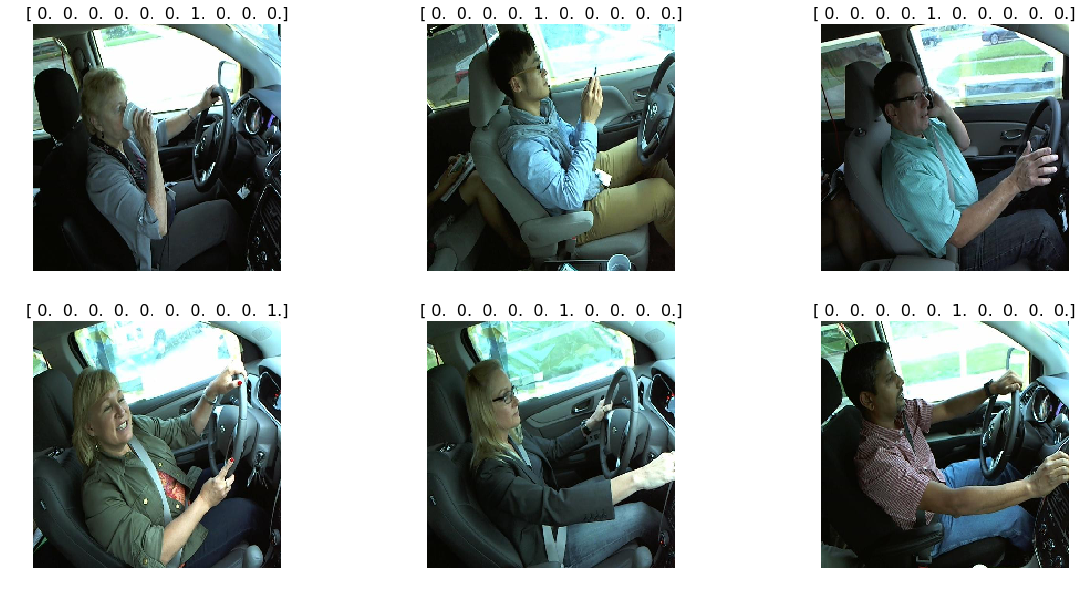

In [125]:
batches = get_batches('train', batch_size=6)
imgs,labels = next(batches)
# Plot randomly 6 images
plots(imgs, titles=labels, figsize=(20,10), rows =2)

Found 5000 images belonging to 10 classes.


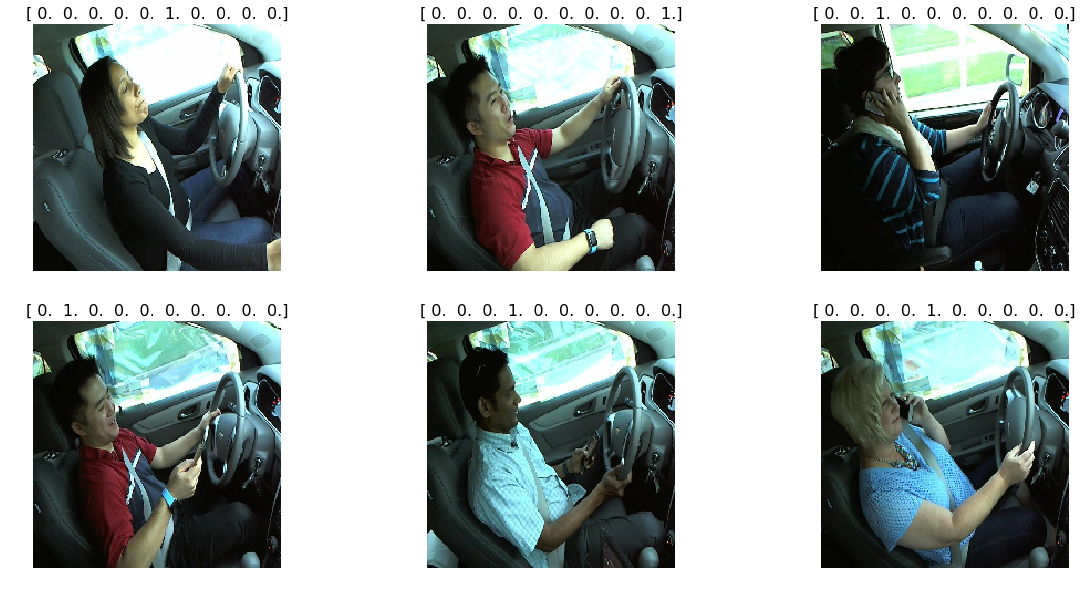

In [141]:
batches = get_batches('valid', batch_size=6)
imgs,labels = next(batches)

# Plot randomly 6 images
plots(imgs, titles=labels, figsize=(20,10), rows =2)

In [174]:
batches = get_batches('test', batch_size=6, class_mode=None)
imgs,labels = next(batches)

# Plot randomly 6 images
plots(imgs, titles=labels, figsize=(20,10), rows =2)

Found 0 images belonging to 0 classes.


ZeroDivisionError: integer division or modulo by zero

## 1.3 Batches preparation

### Batches as direct inputs

<span style="color:red"> WARNING: These lines are only to run once. </span>

In [139]:
%pwd

%cd $test_path


C:\Users\User\Downloads\udacity\project\imgs\test


In [16]:
'''# Roll into pixcel matrix
train_data = get_data('train')
valid_data = get_data('valid')'''

"# Roll into pixcel matrix\ntrain_data = get_data('train')\nvalid_data = get_data('valid')"

In [17]:
%pwd
%cd $path

C:\Users\User\Downloads\udacity\project\imgs


In [18]:
save_array('results/train_data.dat', train_data)
save_array('results/valid_data.dat', valid_data)

"save_array('results/train_data.dat', train_data)\nsave_array('results/valid_data.dat', valid_data)"

<span style="color:red">End  WARNING </span>

Loading labels and stored data.

In [172]:
(valid_classes, 
 train_classes,
 test_batches.classes,
 valid_labels, 
 train_labels, 
 test_labels,
 valid_filenames, 
 train_filenames,
 test_filenames) = get_classes(path)

Found 16774 images belonging to 10 classes.
Found 5000 images belonging to 10 classes.
Found 0 images belonging to 0 classes.


ValueError: not enough values to unpack (expected 9, got 6)

In [170]:
(valid_classes, 
 train_classes,
 test_batches.classes,
 valid_labels, 
 train_labels, 
 test_labels,
 valid_filenames, 
 train_filenames,
labels_filenames) = get_classes(path)

valid_data = load_array(path+'results/valid_data.dat')
train_data = load_array(path+'results/train_data.dat')

Found 16774 images belonging to 10 classes.
Found 5000 images belonging to 10 classes.
Found 0 images belonging to 0 classes.


In [19]:
(valid_classes, 
 train_classes,
 valid_labels, 
 train_labels, 
 valid_filenames, 
 train_filenames) = get_classes(path)

valid_data = load_array(path+'results/valid_data.dat')
train_data = load_array(path+'results/train_data.dat')

Found 16774 images belonging to 10 classes.
Found 5000 images belonging to 10 classes.


In [152]:
%cd $path

C:\Users\User\Downloads\udacity\project\imgs


## 1.3 Summary


# 2. Experiements

We will start with the simpliest model: a fully connected network with no hidden layer, i.e., linear model. This is to provide a benchmark for subsequence development.

Notes:

- We used  batchnormalization right at the input layer to avoid any domination input values that could skew the output.
- We activated the output with a softmax layer for 10 classes.
- We will 224x224 input shape, as the results we will have 1.5+ million parametters and easily overfitted with a linear model, hence, l2 regularization is used to minimize impact of overfitting.

## 2.1 Linear model

In [20]:
Linear_model = Sequential([
        BatchNormalization(axis=-1, input_shape=(224,224,3)),
        Flatten(),
        Dense(10, activation='softmax')
    ])

Linear_model.compile(Adam(lr=10e-5), loss='categorical_crossentropy', metrics=['accuracy'])
Linear_model.summary()            


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1505290   
Total params: 1,505,302
Trainable params: 1,505,296
Non-trainable params: 6
_________________________________________________________________


In [21]:
if 'session' in locals() and session is not None:
    print('Close interactive session')
    session.close()

In [22]:
import tensorflow as tf

allow_soft_placement=True
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=.2, allow_growth = 1)

Training 10 epochs.

In [97]:
batch_size=32
Ex1_history = Linear_model.fit(train_data,train_labels, batch_size=batch_size, epochs=5,
                               validation_data =(valid_data,valid_labels))

Train on 16774 samples, validate on 5000 samples
Epoch 1/5
16774/16774 [==============================] - 192s - loss: 0.8595 - acc: 0.7968 - val_loss: 0.3269 - val_acc: 0.9046
Epoch 2/5
16774/16774 [==============================] - 174s - loss: 0.2319 - acc: 0.9338 - val_loss: 0.4808 - val_acc: 0.8910
Epoch 3/5
16774/16774 [==============================] - 177s - loss: 0.1928 - acc: 0.9482 - val_loss: 0.2319 - val_acc: 0.9496
Epoch 4/5
16774/16774 [==============================] - 175s - loss: 0.1460 - acc: 0.9608 - val_loss: 0.2609 - val_acc: 0.9422
Epoch 5/5
16774/16774 [==============================] - 173s - loss: 0.1587 - acc: 0.9607 - val_loss: 0.1590 - val_acc: 0.9660


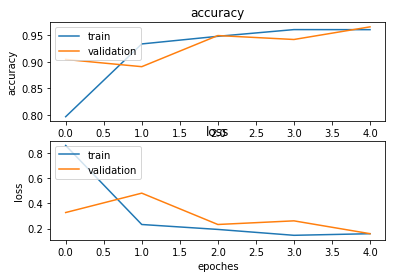

In [99]:
plot_history(Ex1_history)

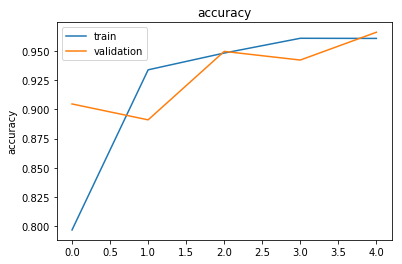

In [103]:
plot_acc(Ex1_history)

In [163]:
train_data


array([[[[  31.,   36.,   27.],
         [  35.,   36.,   38.],
         [  38.,   39.,   38.],
         ..., 
         [ 106.,  181.,  202.],
         [ 127.,  196.,  202.],
         [ 187.,  238.,  236.]],

        [[  32.,   42.,   32.],
         [  33.,   40.,   40.],
         [  36.,   41.,   38.],
         ..., 
         [ 127.,  204.,  221.],
         [ 170.,  240.,  244.],
         [ 196.,  250.,  249.]],

        [[  28.,   44.,   33.],
         [  26.,   39.,   38.],
         [  23.,   35.,   30.],
         ..., 
         [ 160.,  240.,  248.],
         [ 159.,  237.,  239.],
         [ 156.,  220.,  220.]],

        ..., 
        [[  37.,   56.,   46.],
         [  40.,   58.,   50.],
         [  43.,   59.,   53.],
         ..., 
         [  15.,   14.,   12.],
         [  15.,   14.,   12.],
         [  13.,   12.,   10.]],

        [[  37.,   59.,   48.],
         [  38.,   58.,   49.],
         [  43.,   61.,   54.],
         ..., 
         [  16.,   15.,   13.],
       

In [169]:
f1_score(train_labels, valid_labels, average=None)

ValueError: Found input variables with inconsistent numbers of samples: [16774, 5000]

In [118]:
%pwd
%cd ..

C:\Users\User\Downloads\Udacity\project


In [129]:
Linear_model.save_weights(path+'/models/Linear_model.h5')

It can be seen that the linear model with batchnormalization and some l2 regulation actually work pretty well. We can achive validation accuracy of around 94% on the validation dataset. However, the validation accuracy is not stable (even training accuracy is not stable), it means that model will not generalize very well but for starting model, this is very encouraging and it is clearly much better than random guess. 

Next we will try to stablize the validation accuracy with convolutional networks.

## 2.2 Simple convolutional layer network

Next, we experiment a neural network with 2 convolutional layers. This experiment will give us an idea on how this dataset behave under convolutional actions. We will try to overfitting and later adding some regularization or data augmentation.

In [44]:
CNN_simple = Sequential([
            BatchNormalization(input_shape=(224,224,3)),
            Conv2D(32,(3,3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D((3,3)),
            #GlobalAveragePooling2D(data_format=None),
            Conv2D(64,(3,3), activation='relu'),
            BatchNormalization(),
            
            MaxPooling2D((3,3)),
            Flatten(),
            Dense(200, activation='relu'),
            
            BatchNormalization(),
            
            Dense(10, activation='softmax')
        ])

CNN_simple.compile(Adam(lr=10e-5), loss='categorical_crossentropy', metrics=['accuracy'])
CNN_simple.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_69 (Batc (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
batch_normalization_70 (Batc (None, 222, 222, 32)      128       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
batch_normalization_71 (Batc (None, 72, 72, 64)        256       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 24, 24, 64)        0         
__________

In [102]:
batch_size=32
Ex2_history = CNN_simple.fit(train_data,train_labels, batch_size=batch_size, epochs=5, 
                             validation_data =(valid_data,valid_labels))

Train on 16774 samples, validate on 5000 samples
Epoch 1/5
16774/16774 [==============================] - 2489s - loss: 0.2583 - acc: 0.9329 - val_loss: 0.1536 - val_acc: 0.9730
Epoch 2/5
16774/16774 [==============================] - 2408s - loss: 0.0248 - acc: 0.9964 - val_loss: 0.0615 - val_acc: 0.9850
Epoch 3/5
16774/16774 [==============================] - 2396s - loss: 0.0132 - acc: 0.9987 - val_loss: 0.0189 - val_acc: 0.9968
Epoch 4/5
16774/16774 [==============================] - 2341s - loss: 0.0051 - acc: 0.9996 - val_loss: 0.0126 - val_acc: 0.9964
Epoch 5/5
16774/16774 [==============================] - 2283s - loss: 0.0020 - acc: 1.0000 - val_loss: 0.0089 - val_acc: 0.9978


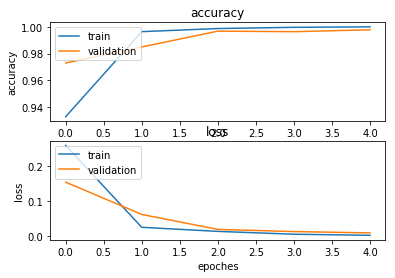

In [104]:
plot_history(Ex2_history)

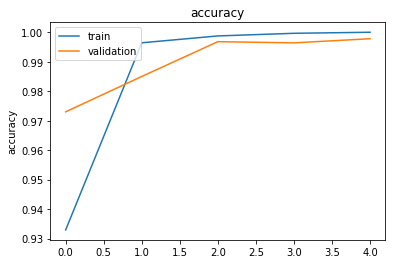

In [105]:
plot_acc(Ex2_history)

In [106]:
CNN_simple.save_weights(path+'models/CNN_simple.h5')

With 4 epochs, we are able to get to 99% accuracy, however, we are slightly overfitting the model, we will add some reularization or specifically dropout to see if we can stablize the accuracy reading a bit more.

## 2.2 Simple convolutional layer network with dropout

Since we will add dropout, e.i., losing some information in order to simplify the model so that we can generalize better but losing information also cause the network less sophisticated, to have a "good" trade-off, we add one more convolutional layer.

In [52]:
CNN_dropout = Sequential([
        BatchNormalization(input_shape=(224,224,3)),
        Conv2D(32,(3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),
    
        Conv2D(64,(3,3), activation='relu'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
    
        Conv2D(128,(3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),
        
        Conv2D(256,(3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),
        AveragePooling2D(),
    
        Flatten(),
        Dense(200, activation='relu'),
        BatchNormalization(),
    
        Dropout(0.5),
        Dense(200, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
CNN_dropout.compile(Adam(lr=10e-5), loss='categorical_crossentropy', metrics=['accuracy'])
CNN_dropout.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_117 (Bat (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
batch_normalization_118 (Bat (None, 222, 222, 32)      128       
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
batch_normalization_119 (Bat (None, 109, 109, 64)      436       
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 54, 54, 64)        0         
__________

In [134]:
batch_size=32
Ex3_history = CNN_dropout.fit(train_data,train_labels, batch_size=batch_size, epochs=2, 
                              validation_data =(valid_data,valid_labels))

Train on 16774 samples, validate on 5000 samples
Epoch 1/2
16774/16774 [==============================] - 237s 14ms/step - loss: -105.7810 - acc: 0.6892 - val_loss: -33.3225 - val_acc: 0.9612
Epoch 2/2
16774/16774 [==============================] - 288s 17ms/step - loss: -185.9037 - acc: 0.9785 - val_loss: -47.0898 - val_acc: 0.9930


In [108]:
Ex3_history = CNN_dropout.fit(train_data,train_labels, batch_size=batch_size, epochs=5, 
                              validation_data =(valid_data,valid_labels))

Train on 16774 samples, validate on 5000 samples
Epoch 1/5
16774/16774 [==============================] - 4820s - loss: 1.6404 - acc: 0.5048 - val_loss: 0.5544 - val_acc: 0.8476
Epoch 2/5
16774/16774 [==============================] - 4894s - loss: 0.5402 - acc: 0.8281 - val_loss: 0.1174 - val_acc: 0.9742
Epoch 3/5
16774/16774 [==============================] - 5652s - loss: 0.2553 - acc: 0.9250 - val_loss: 0.0699 - val_acc: 0.9836
Epoch 4/5
16774/16774 [==============================] - 5774s - loss: 0.1653 - acc: 0.9534 - val_loss: 0.0375 - val_acc: 0.9900
Epoch 5/5
16774/16774 [==============================] - 5587s - loss: 0.1119 - acc: 0.9683 - val_loss: 0.0555 - val_acc: 0.9842


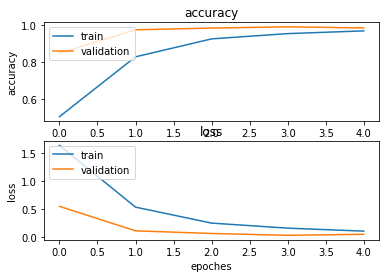

In [109]:
plot_history(Ex3_history)

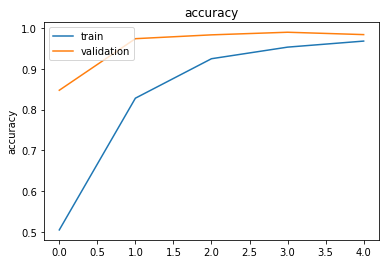

In [110]:
plot_acc(Ex3_history)

In [122]:
CNN_dropout.save_weights(path+'models/CNN_dropout.h5')

## 2.4. Using vgg16 model without pre-trained weights

- Preprocessing input data specifically for vgg network
- Put common blocks into functions
- Add batchnormalixation layers (since vgg16 was invented before the introduction of batchnorn , original vgg16 does not contain batchnorm layers)

### vgg16 model construction

### Batches as outputs from vgg16 pretained weights

We will leverage the pre-trained imageNet weights available for vgg16 models.

To do this, it is easier to precompute outputs of vgg16's convolutional part and use these outputs as our inputs to our models. This process will help to save time as well as memory.

In [54]:
from keras.applications.vgg16 import VGG16
vgg_model_orig = VGG16(weights='imagenet', include_top=True)

Freeze the convolutional part

In [55]:
# Pop all the layers in Vgg model
layers = vgg_model_orig.layers
# Find all the index of Convolution2D layers
Con2D_layer_idx = [index for index,layer in enumerate(layers) if type(layer) is Conv2D]
# Call the index of the last Convolution2D layer
layer_idx = Con2D_layer_idx[-1]

# Find out what it is
layer_idx

17

In [56]:
Con2D_layer_idx

[1, 2, 4, 5, 7, 8, 9, 11, 12, 13, 15, 16, 17]

In [57]:
vgg_model_orig.output.shape

TensorShape([Dimension(None), Dimension(1000)])

In [58]:
# Create convolutional model up to layer 30
conv_model = Sequential(layers[:layer_idx+1])
conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [78]:
x = conv_model.output
x = MaxPooling2D()(x)
x = AveragePooling2D()(x)
x = MaxPooling2D()(x)


x = Flatten()(x)

x = Dense(4096, activation='relu')(x)
x = BatchNormalization()(x)

x = Dropout(0.5)(x)

x = Dense(4096, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

output = Dense(10, activation='softmax')(x) # output 10 classes
vgg_model = Model(inputs = conv_model.input, outputs = output)

In [79]:
# Set all the convolutional layers to nontrainable
for layer in conv_model.layers:
    layer.trainable = False
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [80]:
vgg_model.compile(Adam(lr=10e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [118]:
batch_size = 1
Ex41_history = vgg_model.fit(train_data,train_labels, batch_size=batch_size, epochs=3, 
                              validation_data =(valid_data,valid_labels))

Train on 16774 samples, validate on 5000 samples
Epoch 1/3
16774/16774 [==============================] - 14618s - loss: 2.2926 - acc: 0.1146 - val_loss: 14.4584 - val_acc: 0.1028
Epoch 2/3
16774/16774 [==============================] - 15513s - loss: 2.2930 - acc: 0.1118 - val_loss: 14.4540 - val_acc: 0.1026
Epoch 3/3
16774/16774 [==============================] - 14967s - loss: 2.2929 - acc: 0.1108 - val_loss: 14.3356 - val_acc: 0.1098


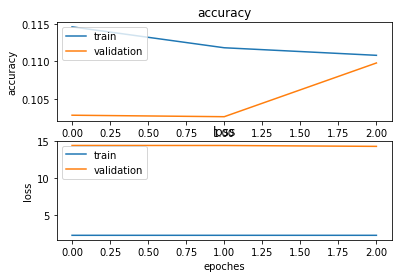

In [119]:
plot_history(Ex41_history)

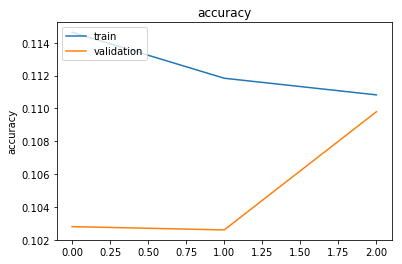

In [120]:
plot_acc(Ex41_history)

In [123]:
vgg_model.save_weights(path+'models/vgg_model.h5')

## 2.5 Using InceptionV3 model with transfered learning (pretrained weights)

In this experiment, we will use InceptionV3 model with pre-trained imageNet weights. We will first start with the base model with slightly modification of the top layer to adapt with 10 classes instead 1000 classes. 

### Base model

In [84]:
from keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(10, activation='softmax')(x) # output 10 classes
IcepV3_model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False
IcepV3_model.compile(Adam(lr=10e-5), loss='categorical_crossentropy', metrics=['accuracy'])
IcepV3_model.summary()

87826432/87910968 [============================>.] - ETA: 0s____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv2d_252 (Conv2D)              (None, None, None, 32 864         input_4[0][0]                    
____________________________________________________________________________________________________
batch_normalization_328 (BatchNo (None, None, None, 32 96          conv2d_252[0][0]                 
____________________________________________________________________________________________________
activation_189 (Activation)      (None, None, None, 32 0           batch_normalization_328[0][0]    
_______________________________

In [85]:
batch_size=32
Ex4_history = IcepV3_model.fit(train_data,train_labels, batch_size=batch_size, epochs=3, 
                              validation_data =(valid_data,valid_labels))

Train on 16774 samples, validate on 5000 samples
Epoch 1/3
16774/16774 [==============================] - 3654s - loss: 1.4326 - acc: 0.5639 - val_loss: 0.8979 - val_acc: 0.7318
Epoch 2/3
16774/16774 [==============================] - 3654s - loss: 0.7781 - acc: 0.7829 - val_loss: 0.5889 - val_acc: 0.8428
Epoch 3/3
16774/16774 [==============================] - 3639s - loss: 0.5853 - acc: 0.8370 - val_loss: 0.4632 - val_acc: 0.8762


In [86]:
Ex4_history = IcepV3_model.fit(train_data,train_labels, batch_size=batch_size, epochs=5, 
                              validation_data =(valid_data,valid_labels))

Train on 16774 samples, validate on 5000 samples
Epoch 1/5
16774/16774 [==============================] - 3613s - loss: 0.4872 - acc: 0.8605 - val_loss: 0.4367 - val_acc: 0.8754
Epoch 2/5
16774/16774 [==============================] - 3595s - loss: 0.4147 - acc: 0.8812 - val_loss: 0.3730 - val_acc: 0.8940
Epoch 3/5
16774/16774 [==============================] - 3686s - loss: 0.3754 - acc: 0.8894 - val_loss: 0.3546 - val_acc: 0.8990
Epoch 4/5
16774/16774 [==============================] - 3621s - loss: 0.3242 - acc: 0.9085 - val_loss: 0.3383 - val_acc: 0.8996
Epoch 5/5
16774/16774 [==============================] - 4035s - loss: 0.2987 - acc: 0.9158 - val_loss: 0.2790 - val_acc: 0.9236


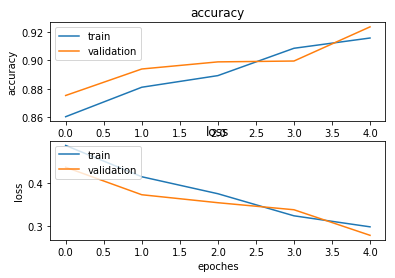

In [90]:
plot_history(Ex4_history)

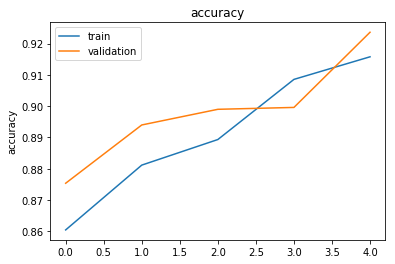

In [112]:
plot_acc(Ex4_history)

We are already overfitting the model, validation accuaracy stays around 0.91 and it seems like Inception3 net without modification further layers will not preduce a good results.

### Further finetuning
Next, we will further fine-tune InceptionV3 models. We will freeze the first 172 layers and train the rest

In [88]:
# the first 172 layers and unfreeze the rest:
for layer in IcepV3_model.layers[:172]:
    layer.trainable = False
for layer in IcepV3_model.layers[172:]:
    layer.trainable = True

In [92]:
IcepV3_model.compile(Adam(lr=10e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [93]:
Ex5_history = IcepV3_model.fit(train_data,train_labels, batch_size=batch_size, epochs=5, 
                              validation_data =(valid_data,valid_labels))

Train on 16774 samples, validate on 5000 samples
Epoch 1/5
16774/16774 [==============================] - 5627s - loss: 0.1324 - acc: 0.9589 - val_loss: 0.0700 - val_acc: 0.9808
Epoch 2/5
16774/16774 [==============================] - 5203s - loss: 0.0212 - acc: 0.9937 - val_loss: 0.0243 - val_acc: 0.9918
Epoch 3/5
16774/16774 [==============================] - 4885s - loss: 0.0209 - acc: 0.9937 - val_loss: 0.0252 - val_acc: 0.9940
Epoch 4/5
16774/16774 [==============================] - 4807s - loss: 0.0318 - acc: 0.9914 - val_loss: 0.0245 - val_acc: 0.9934
Epoch 5/5
16774/16774 [==============================] - 4819s - loss: 0.0093 - acc: 0.9973 - val_loss: 0.0324 - val_acc: 0.9914


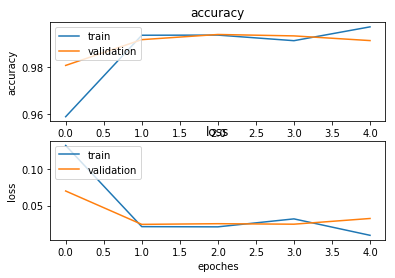

In [94]:
plot_history(Ex5_history)

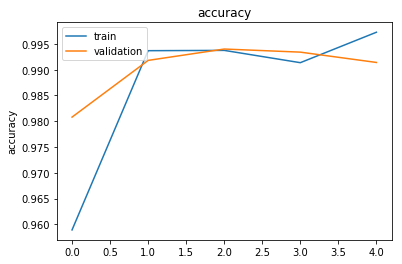

In [117]:
plot_acc(Ex5_history)

In [116]:
IcepV3_model.save_weights(path+'models/IcepV3_model.h5')